In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from datetime import datetime
from math import *
from util import *
from dateutil.relativedelta import relativedelta # $ pip install python-dateutil

palette = sns.color_palette('Paired', 12)
plt.rcParams["figure.figsize"] = (13, 6)

In [74]:
df_west = pd.read_csv('data/CitiesWestChunk.csv', parse_dates=[0])
df_west['year'] = df_west['date'].apply(lambda d: d.year)
df_east = pd.read_csv('data/CitiesEastChunk.csv', parse_dates=[0])
df_east['year'] = df_east['date'].apply(lambda d: d.year)

cities = df_east['city'].unique()

date_from = 1900
date_to = 2010

el_paso = df_west.groupby(['year', 'city'], as_index=False).mean().query('city == "El Paso" & year >= @date_from')
cleveland = df_east.groupby(['year', 'city'], as_index=False).mean().query('city == "Cleveland" & year >= @date_from')

# compute east
df_east = df_east.query('year <= @date_to').query('year >= @date_from').groupby(['year', 'city'], as_index=False).mean()
df_east = df_east.pivot(index='year', columns='city')['avg']
df_east.head()

# compute west
df_west = df_west.query('year <= @date_to').query('year >= @date_from').groupby(['year', 'city'], as_index=False).mean()
df_west = df_west.pivot(index='year', columns='city')['avg']
df_west.head()

city,Albuquerque,Anaheim,Bakersfield,Chandler,Chula Vista,El Paso,Fresno,Glendale,Henderson,Las Vegas,...,Riverside,Sacramento,San Diego,San Francisco,San Jose,Santa Ana,Scottsdale,Seattle,Stockton,Tucson
year,,,,,,,,,,,,,,,,,,,,,
1900,11.599333,16.497833,15.719750,21.345833,16.497833,15.984167,15.719750,18.712417,17.835667,17.835667,...,17.227083,14.642000,16.497833,14.642000,14.642000,16.497833,21.345833,7.952583,14.642000,18.093167
1901,11.410333,16.029833,15.777083,21.080750,16.029833,15.988000,15.777083,18.399667,17.624583,17.624583,...,17.107250,14.339500,16.029833,14.339500,14.339500,16.029833,21.080750,7.267000,14.339500,17.718917
1902,11.120250,15.315167,15.110333,20.970917,15.315167,16.041500,15.110333,18.023583,17.040083,17.040083,...,16.425500,14.066917,15.315167,14.066917,14.066917,15.315167,20.970917,7.334667,14.066917,17.732750
1903,10.485750,15.742000,15.324333,20.841083,15.742000,15.171083,15.324333,18.163708,17.131750,17.131750,...,16.682500,14.124000,15.742000,14.124000,14.124000,15.742000,20.841083,6.979250,14.124000,17.496250
1904,11.095667,16.380250,16.039500,21.287750,16.380250,15.670583,16.039500,18.762292,17.707500,17.707500,...,17.431000,14.502083,16.380250,14.502083,14.502083,16.380250,21.287750,7.702667,14.502083,17.704000


### Mayores amplitudes

In [125]:
g_w = pd.read_csv('data/CitiesWestChunk.csv').groupby('city').aggregate(['min', 'max'])
g_w['diff'] = g_w['avg']['max'] - g_w['avg']['min']
print('Top 5 amplitud West')
print(g_w.sort_values('diff').iloc[-5:]['diff'])
west_cities_top_amp = g_w.index.values[-5:]

print('*' * 30)

g_e = pd.read_csv('data/CitiesEastChunk.csv').groupby('city').aggregate(['min', 'max'])
g_e['diff'] = g_e['avg']['max'] - g_e['avg']['min']
print('Top 5 amplitud East')
print(g_e.sort_values('diff').iloc[-5:]['diff'])
east_cities_top_amp = g_e.index.values[-5:]

Top 5 amplitud West
city
Glendale       30.363
Albuquerque    30.761
Paradise       33.867
Las Vegas      33.867
Henderson      33.867
Name: diff, dtype: float64
******************************
Top 5 amplitud East
city
Detroit       39.951
Cleveland     40.013
Pittsburgh    40.013
Akron         40.013
Toledo        40.850
Name: diff, dtype: float64


### Altitud < 100

In [107]:
g_w = pd.read_csv('data/CitiesWestChunk.csv').groupby('city').first()
g_w = g_w.query('altitude < 100')
print('Menos de 100m West')
print(g_w['altitude'])
west_cities_less_100 = g_w.index.values

print('*' * 30)

g_e = pd.read_csv('data/CitiesEastChunk.csv').groupby('city').first()
g_e = g_e.query('altitude < 100')
print('Menos de 100m East')
print(g_e['altitude'])
east_cities_less_100 = g_e.index.values

Menos de 100m West
city
Anaheim          40
Chula Vista      23
Fresno           91
Long Beach        1
Modesto          12
Oakland           0
Phoenix           0
Portland         61
Sacramento        5
San Diego        26
San Francisco    60
San Jose         24
Santa Ana        30
Seattle          60
Stockton          4
Name: altitude, dtype: int64
******************************
Menos de 100m East
city
Baltimore            2
Boston              11
Hialeah              2
Jacksonville         7
Jersey City         14
Miami                2
Newark              16
Norfolk              3
Orlando             34
Philadelphia         8
Raleigh             91
Saint Petersburg    14
Tampa                1
Virginia Beach       3
Washington          11
Name: altitude, dtype: int64


# El paso

### Todas

In [118]:
nameCols = ['avg ' + c for c in cities]

total_el_paso = []
for chunk in range(1920, 2005):
    hasta = chunk + 5
    df_tr = df_east.query('year < @chunk')
    df_tt = df_east.query('year >= @chunk & year < @hasta')

    xs = df_tr.as_matrix()
    nc = len(nameCols)

    f = cml(lambda x: [1] + [x[i] for i in range(nc)], xs, el_paso.query('year < @chunk')['avg'])
    results_tr = list(map(f, df_tr.as_matrix()))
    results_tt = list(map(f, df_tt.as_matrix()))

    err = ecm(results_tt, el_paso.query('year >= @chunk & year < @hasta')['avg'])
    total_el_paso.append(err)

### Menos de 100m

In [119]:
nameCols = ['avg ' + c for c in east_cities_less_100]
df_east_100 = df_east[east_cities_less_100]

total_el_paso_100 = []
for chunk in range(1920, 2005):
    hasta = chunk + 5
    df_tr = df_east_100.query('year < @chunk')
    df_tt = df_east_100.query('year >= @chunk & year < @hasta')

    xs = df_tr.as_matrix()
    nc = len(nameCols)

    f = cml(lambda x: [1] + [x[i] for i in range(nc)], xs, el_paso.query('year < @chunk')['avg'])
    results_tr = list(map(f, df_tr.as_matrix()))
    results_tt = list(map(f, df_tt.as_matrix()))

    err = ecm(results_tt, el_paso.query('year >= @chunk & year < @hasta')['avg'])
    total_el_paso_100.append(err)

### Amplitud Top 5

In [126]:
nameCols = ['avg ' + c for c in east_cities_top_amp]
df_east_top = df_east[east_cities_top_amp]

total_el_paso_top = []
for chunk in range(1920, 2005):
    hasta = chunk + 5
    df_tr = df_east_top.query('year < @chunk')
    df_tt = df_east_top.query('year >= @chunk & year < @hasta')

    xs = df_tr.as_matrix()
    nc = len(nameCols)

    f = cml(lambda x: [1] + [x[i] for i in range(nc)], xs, el_paso.query('year < @chunk')['avg'])
    results_tr = list(map(f, df_tr.as_matrix()))
    results_tt = list(map(f, df_tt.as_matrix()))

    err = ecm(results_tt, el_paso.query('year >= @chunk & year < @hasta')['avg'])
    total_el_paso_top.append(err)

                     ECM       max       min
Todas           0.436834  2.321951  0.073482
Menos 100m      0.308179  0.800785  0.034849
Top 5 amplitud  0.273082  0.723342  0.033659


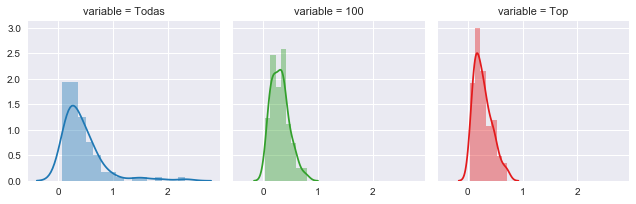

In [178]:
print(pd.DataFrame(data=[
    [sum(total_el_paso)/len(total_el_paso), max(total_el_paso), min(total_el_paso)],
    [sum(total_el_paso_100)/len(total_el_paso_100), max(total_el_paso_100), min(total_el_paso_100)],
    [sum(total_el_paso_top)/len(total_el_paso_top), max(total_el_paso_top), min(total_el_paso_top)],
    ], columns=['ECM', 'max', 'min'], index=['Todas', 'Menos 100m', 'Top 5 amplitud']))

#plt.plot(range(1920, 2005), total_el_paso, label='ECM Oeste vs El Paso')
#plt.plot(range(1920, 2005), total_el_paso_100, label='ECM Oeste < 100m vs El Paso')
#plt.plot(range(1920, 2005), total_el_paso_top, label='ECM Top 5 Amplitud Oeste vs El Paso')
#plt.legend()
lolz = pd.DataFrame([total_el_paso, total_el_paso_100, total_el_paso_top], index=['Todas', '100', 'Top']).transpose()
x = 1
def kaka(data, color):
    global x
    sns.distplot(a=data['value'], color=palette[x])
    x += 2
sns.FacetGrid(data=pd.melt(lolz), col='variable').map_dataframe(kaka) 

# Cleveland

### Todas

In [180]:
nameCols = ['avg ' + c for c in cities]

total_cleveland = []
for chunk in range(1920, 2005):
    hasta = chunk + 5
    df_tr = df_west.query('year < @chunk')
    df_tt = df_west.query('year >= @chunk & year < @hasta')

    xs = df_tr.as_matrix()
    nc = len(nameCols)

    f = cml(lambda x: [1] + [x[i] for i in range(nc)], xs, cleveland.query('year < @chunk')['avg'])
    results_tr = list(map(f, df_tr.as_matrix()))
    results_tt = list(map(f, df_tt.as_matrix()))

    err = ecm(results_tt, cleveland.query('year >= @chunk & year < @hasta')['avg'])
    total_cleveland.append(err)

### Menos 100m

In [184]:
nameCols = ['avg ' + c for c in west_cities_less_100]
df_west_100 = df_west[west_cities_less_100]

total_cleveland_100 = []
for chunk in range(1920, 2005):
    hasta = chunk + 5
    df_tr = df_west_100.query('year < @chunk')
    df_tt = df_west_100.query('year >= @chunk & year < @hasta')

    xs = df_tr.as_matrix()
    nc = len(nameCols)

    f = cml(lambda x: [1] + [x[i] for i in range(nc)], xs, cleveland.query('year < @chunk')['avg'])
    results_tr = list(map(f, df_tr.as_matrix()))
    results_tt = list(map(f, df_tt.as_matrix()))

    err = ecm(results_tt, cleveland.query('year >= @chunk & year < @hasta')['avg'])
    total_cleveland_100.append(err)

### Top 5

In [185]:
nameCols = ['avg ' + c for c in west_cities_top_amp]
df_west_top = df_west[west_cities_top_amp]

total_cleveland_top = []
for chunk in range(1920, 2005):
    hasta = chunk + 5
    df_tr = df_west_top.query('year < @chunk')
    df_tt = df_west_top.query('year >= @chunk & year < @hasta')

    xs = df_tr.as_matrix()
    nc = len(nameCols)

    f = cml(lambda x: [1] + [x[i] for i in range(nc)], xs, cleveland.query('year < @chunk')['avg'])
    results_tr = list(map(f, df_tr.as_matrix()))
    results_tt = list(map(f, df_tt.as_matrix()))

    err = ecm(results_tt, cleveland.query('year >= @chunk & year < @hasta')['avg'])
    total_cleveland_top.append(err)

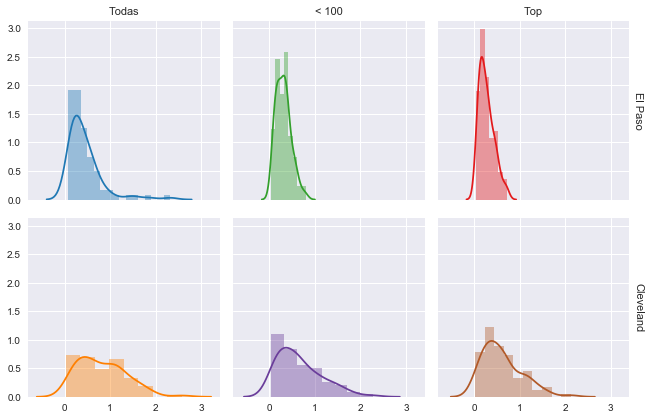

In [237]:
tabla = pd.DataFrame(data=[
    [sum(total_el_paso)/len(total_el_paso), max(total_el_paso), min(total_el_paso), 'Todas', 'El Paso'],
    [sum(total_el_paso_100)/len(total_el_paso_100), max(total_el_paso_100), min(total_el_paso_100), '< 100m', 'El Paso'],
    [sum(total_el_paso_top)/len(total_el_paso_top), max(total_el_paso_top), min(total_el_paso_top), 'Top 5 amplitud', 'El Paso'],
    
    [sum(total_cleveland)/len(total_cleveland), max(total_cleveland), min(total_cleveland), 'Todas', 'Cleveland'],
    [sum(total_cleveland_100)/len(total_cleveland_100), max(total_cleveland_100), min(total_cleveland_100), '< 100m', 'Cleveland'],
    [sum(total_cleveland_top)/len(total_cleveland_top), max(total_cleveland_top), min(total_cleveland_top), 'Top 5 amplitud', 'Cleveland'],
    ], columns=['ECM', 'max', 'min', 'kind', 'coast'])

count = len(total_cleveland)
lolz = pd.DataFrame({'err': total_el_paso + total_el_paso_100 + total_el_paso_top +
                            total_cleveland + total_cleveland_100 + total_cleveland_top,
                     'kind': (['Todas']*count + ['< 100']*count + ['Top']*count)*2,
                     'coast': ['El Paso']*count*3 + ['Cleveland']*count*3})

x = 1
def kaka(data, color):
    global x
    sns.distplot(data['err'], color=palette[x])
    x += 2

g = sns.FacetGrid(data=lolz, col='kind', row='coast', margin_titles=True)\
    .map_dataframe(kaka)
[plt.setp(ax.texts, text="") for ax in g.axes.flat]
g.set_titles(None, '{row_name}', '{col_name}')